In [1]:
import json
import os
import sys
import datetime
from pathlib import Path
from IPython.display import Markdown, display

from pydantic import BaseModel, Field, model_validator
from pydantic_ai import Agent

In [2]:
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

In [3]:
from gepadantic import SignatureAgent, GepaConfig, run_optimization_pipeline, split_dataset
from gepadantic.lm import get_openai_model
from gepadantic.schema import DataInstWithInput, RolloutOutput, InputModelT

In [4]:
with open('../data/dummy_medical_records.json', 'r') as f:
    medical_records = json.load(f)

In [5]:
class MedicalRecord(BaseModel):
    """A single medical record with associated metadata."""
    
    medical_record: str = Field(description="Full text of the medical record")
    date_of_service: datetime.date = Field(description="Date of service")
    user_feedback: str | None = Field(default=None, description="User feedback on the record")
    
    def __str__(self):
        out_string = ""
        out_string += f"**Date of Service**: {self.date_of_service}\n\n"
        out_string += f"**Medical Record**: {self.medical_record[:180]}...\n\n"
        out_string += f"**User Feedback**: {self.user_feedback}\n\n"
        out_string += "---\n\n"
        return out_string


class MedicalRecords(BaseModel):
    """Collection of medical records."""
    
    records: list[MedicalRecord] = Field(description="List of medical records")
    
    @classmethod
    def from_json_file(cls, file_path: str | Path) -> "MedicalRecords":
        """Load medical records from a JSON file.
        
        Args:
            file_path: Path to the JSON file containing an array of medical records
            
        Returns:
            MedicalRecords object containing the parsed records
        """
        path = Path(file_path)
        with path.open('r', encoding='utf-8') as f:
            data = json.load(f)
        
        return cls(records=data)

In [6]:
records = MedicalRecords.from_json_file('../data/dummy_medical_records.json')

len(records.records)

10

In [7]:
for record in records.records[:3]:
    display(Markdown(str(record)))

**Date of Service**: 2025-04-02

**Medical Record**: EMERGENCY MEDICAL SERVICES RUN REPORT

Patient Name: Jonathan Parker
DOB: 03/22/1987
Sex: Male
Incident Date/Time: 04/02/2025 17:38
Date of Service: 04/02/2025
Run Number: EMS-25-1...

**User Feedback**: Summary should not include full DOB, only their current age and city/state of residence. I also think bullet point would be easier to read.

---



**Date of Service**: 2025-04-02

**Medical Record**: EMERGENCY DEPARTMENT VISIT NOTE

Facility: Starlight Regional Medical Center
Address: 2100 W 5th St, Austin, TX 78703
ED Encounter #: ED-25-449302
Date of Service: 04/02/2025

Pati...

**User Feedback**: Their correct age as of 1/1/2026 is 38. Residence should be limited to city and state only, not the full address. on the records we just need a high level breakdown, no need to go into things like vital signs. 

---



**Date of Service**: 2025-04-02

**Medical Record**: DIAGNOSTIC IMAGING REPORT – CT CERVICAL SPINE

Facility: Starlight Regional Medical Center Radiology Department
Address: 2100 W 5th St, Austin, TX 78703
Exam Date / Date of Service...

**User Feedback**: If we have impressions we don't need to include findings as well. However we do need specific objective results from the imaging studies.

---



In [8]:
class MedicalRecordInput(BaseModel):
    """A single medical document with associated metadata."""
    
    text: str = Field(description="Full text of the medical document")


class MedicalRecordOutput(BaseModel):
    """A single entry in the medical chronology."""
    
    date_of_service: datetime.date = Field(description="Date of service")
    provider_name: str = Field(description="Name of the provider")
    description: str = Field(description="Description entry for a chronology")
    
    def __str__(self):
        return f"{self.date_of_service}\n\n{self.provider_name}\n\n{self.description}"


In [9]:
Markdown(records.records[0].medical_record)

EMERGENCY MEDICAL SERVICES RUN REPORT

Patient Name: Jonathan Parker
DOB: 03/22/1987
Sex: Male
Incident Date/Time: 04/02/2025 17:38
Date of Service: 04/02/2025
Run Number: EMS-25-18432

Pickup Location: I-35 Northbound at Exit 247, Austin, TX 78753
Destination Facility: Starlight Regional Medical Center, 2100 W 5th St, Austin, TX 78703

Primary Insurance: Lone Star Auto & Casualty, Claim #LSA-2025-48192
Secondary Insurance: SilverShield Health PPO, Member ID: SSH-77492038-01

CHIEF COMPLAINT:
Motor vehicle collision. Patient was restrained driver rear-ended at highway speed, complaining of neck pain, mid-back pain, and frontal headache.

HISTORY OF PRESENT ILLNESS:
38-year-old male involved in rear-end MVC at approximately 17:20. Patient reports being stopped in traffic when struck from behind by a pickup truck. No airbag deployment. Denies loss of consciousness but reports feeling "dazed" for several seconds. Self-extricated from vehicle and was ambulatory on scene. Complaints: 6/10 neck pain radiating to shoulders, 5/10 mid-thoracic pain, mild nausea, and 4/10 frontal headache. Denies chest pain, shortness of breath, abdominal pain, or extremity numbness/weakness.

PAST MEDICAL HISTORY:
- Hypertension
- Hyperlipidemia

MEDICATIONS:
- Lisinopril 10 mg PO daily
- Atorvastatin 20 mg PO nightly

ALLERGIES:
- NKDA (No known drug allergies)

VITAL SIGNS AT 17:44:
- BP: 148/92 mmHg
- HR: 92 bpm
- RR: 18 breaths/min
- SpO2: 98% on room air
- GCS: 15 (E4, V5, M6)

PHYSICAL EXAM (FIELD):
- General: Alert, oriented x3, mildly anxious, in mild distress due to pain.
- HEENT: Pupils equal, round, reactive to light. No scalp lacerations or hematomas.
- Neck: Midline cervical spine tenderness at C4–C6. No step-offs. C-collar applied.
- Chest: Breath sounds clear bilaterally. No chest wall tenderness.
- Cardiovascular: Regular rate and rhythm, no murmurs.
- Abdomen: Soft, non-tender, no ecchymosis.
- Back: Midline tenderness over T6–T8, no deformity.
- Neuro: Strength 5/5 in all extremities. Sensation intact. No focal deficits.

TREATMENTS PROVIDED:
- Cervical spine immobilization with rigid collar
- Long spine board for transport
- IV access: 18G right antecubital
- Normal saline 0.9% at TKO
- Fentanyl 50 mcg IV at 17:52 for pain (pain improved from 6/10 to 4/10)

TRANSPORT & HANDOFF:
Transported emergently (Code 2) to Starlight Regional Medical Center ED. Handoff report given to RN Sarah Wilcox, RN license #RN-882944, and ED attending Dr. Michael R. Hargrove at 18:09.

BILLING SUMMARY:

| Service Code | Description                         | Units | Charge (USD) |
|-------------|-------------------------------------|-------|--------------|
| A0427       | ALS Emergency Transport             | 1     | 850.00       |
| A0425       | Ground Mileage (per mile)           | 12    | 180.00       |
| A0398       | IV Supplies and Medication Handling | 1     | 95.00        |
| J3010       | Fentanyl Citrate Injection          | 1     | 60.00        |

Provider: EMT-P Daniel Rivera, License #EMTP-21478
Electronic Signature Date: 04/02/2025 19:02

This record is intended for claims processing and medical review by Starlight Regional Medical Center, Lone Star Auto & Casualty (Adjuster: Melissa Grant, Direct Line: 512-555-6231), and SilverShield Health PPO.

In [10]:
from gepadantic.schema import DataInstWithPrompt
from pydantic_ai.messages import UserPromptPart

def init_dataset(
    input_data: list[MedicalRecords],
) -> list[DataInstWithPrompt]:
    """Load data from a list of dicts and convert to DataInstWithInput instances."""
    
    dataset: list[DataInstWithPrompt] = []

    for idx, record in enumerate(input_data.records):
        
        input_string = record.medical_record

        # Extract metadata
        metadata = dict(
            date_of_service=record.date_of_service,
            user_feedback=record.user_feedback,
        )

        case_id = f"item-{idx}"

        # Create DataInstWithInput
        data_inst = DataInstWithPrompt(
            user_prompt=UserPromptPart(content=input_string),
            message_history=None,
            metadata=metadata,
            case_id=case_id,
        )
        dataset.append(data_inst)

    return dataset

In [11]:
dataset = init_dataset(records)

In [12]:
dataset[0].__dict__

{'user_prompt': UserPromptPart(content='EMERGENCY MEDICAL SERVICES RUN REPORT\n\nPatient Name: Jonathan Parker\nDOB: 03/22/1987\nSex: Male\nIncident Date/Time: 04/02/2025 17:38\nDate of Service: 04/02/2025\nRun Number: EMS-25-18432\n\nPickup Location: I-35 Northbound at Exit 247, Austin, TX 78753\nDestination Facility: Starlight Regional Medical Center, 2100 W 5th St, Austin, TX 78703\n\nPrimary Insurance: Lone Star Auto & Casualty, Claim #LSA-2025-48192\nSecondary Insurance: SilverShield Health PPO, Member ID: SSH-77492038-01\n\nCHIEF COMPLAINT:\nMotor vehicle collision. Patient was restrained driver rear-ended at highway speed, complaining of neck pain, mid-back pain, and frontal headache.\n\nHISTORY OF PRESENT ILLNESS:\n38-year-old male involved in rear-end MVC at approximately 17:20. Patient reports being stopped in traffic when struck from behind by a pickup truck. No airbag deployment. Denies loss of consciousness but reports feeling "dazed" for several seconds. Self-extricated f

In [13]:
from sqlite3 import Date
from typing import TypeVar
from pydantic import BaseModel, Field

InputModelT = TypeVar("InputModelT")

model = get_openai_model("gpt-4.1")


class EvaluationInput(BaseModel):
    model_input: str = Field(description="Model input")
    model_output: MedicalRecordOutput = Field(description="Model output")
    user_feedback: str | None = Field(default=None, description="Optional user feedback")


class Score10(BaseModel):
    """Discrete score 0..10."""
    score: int = Field(ge=0, le=10, description="Integer score from 0 to 10")
    explanation: str | None = Field(
        default=None,
        description="Required if score < 8",
    )

    @model_validator(mode="after")
    def _require_explanation_if_not_perfect(self) -> "Score10":
        if self.score < 8 and not self.explanation:
            raise ValueError("explanation is required when score < 8")
        return self


class EvaluationResult(BaseModel):
    accuracy: Score10 = Field(description="Factual alignment between output and input")
    guidelines: Score10 = Field(description="Guideline adherence")
    user_feedback: Score10 | None = Field(
        default=None,
        description="Only present if user_feedback was provided",
    )


base_metric_agent = Agent(
    model=model,
    output_type=EvaluationResult,
    instructions="""\
You are a quality control agent for a medical chronology extraction and summarization application.

Return integer scores 0..10 (inclusive):
- 10 = perfect for that dimension
- 0 = unusable for that dimension
If a score is < 8, include an informative explanation.

Dimensions:
1) accuracy: factual alignment of output vs input text (hallucinations/misstatements are heavily penalized)
2) guidelines: adherence to guidelines below
3) user_feedback:
   - If user_feedback is provided, score how well the output respects it.
   - If user_feedback is NOT provided, set user_feedback to null (omit it).
   
Note:
- User feedback may be from a previous run, or general comments.
- The feedback is not specific to the current output, but rather existing feedback that we should respect.

Guidelines:
- The description should be concise and information dense.
- Formatting should be minimalistic.
- There should be NO general statements, broad observations, or otherwise synthesized narrative.
- Forbid full date of birth.
- Residency should be restricted to city and state only.
"""
)

metric_signature_agent = SignatureAgent(
    base_metric_agent, 
    input_type=EvaluationInput,
)


def _to01(score10: int) -> float:
    # exact mapping 0..10 -> 0.0..1.0
    return score10 / 10.0


def _fmt(name: str, s: Score10 | None) -> str:
    if s is None:
        return f"{name}=N/A"
    if s.explanation:
        return f"{name}={s.score}/10: {s.explanation}"
    return f"{name}={s.score}/10"


def chronology_metric(
    data_inst: DataInstWithPrompt,
    output: RolloutOutput[MedicalRecordOutput],
) -> tuple[float, str]:

    if not output.success:
        return 0.0, "Failed to extract chronology entry"

    expected_dos = data_inst.metadata["date_of_service"]
    if output.result.date_of_service != expected_dos:
        return 0.0, "Date of service is not correct. This is critical to a medical chronology."

    evaluation_input = EvaluationInput(
        model_input=data_inst.user_prompt.content,
        model_output=output.result,
        user_feedback=data_inst.metadata.get("user_feedback"),
    )

    evaluation_response = metric_signature_agent.run_signature_sync(evaluation_input)
    ev: EvaluationResult = evaluation_response.output

    g = _to01(ev.guidelines.score)
    a = _to01(ev.accuracy.score)
    f = _to01(ev.user_feedback.score) if ev.user_feedback is not None else 1.0

    final = (g + a + f) / 3.0

    lines = [
        f"Final={final:.3f} = guidelines({g:.3f}) × accuracy({a:.3f}) × feedback({f:.3f})",
        _fmt("Guidelines", ev.guidelines),
        _fmt("Accuracy", ev.accuracy),
        _fmt("User feedback", ev.user_feedback),
    ]
    return final, "\n".join(lines)


In [14]:
train_set, val_set = split_dataset(dataset, train_ratio=0.5, shuffle=True, random_seed=1)

In [15]:
import nest_asyncio

nest_asyncio.apply()


TEST_TEXT = records.records[0].medical_record


DEFAULT_INSTRUCTIONS = "Generate a medical chronology entry from the given text."

llm = get_openai_model("gpt-4.1-nano")

base_agent = Agent(
    model=llm,
    output_type=MedicalRecordOutput,
    instructions=DEFAULT_INSTRUCTIONS,
)

base_result = base_agent.run_sync(TEST_TEXT)

In [16]:
base_output_summary = str(base_result.output)

Markdown(base_output_summary)

2025-04-02

EMT-P Daniel Rivera

Emergency medical services run report for patient Jonathan Parker involved in a motor vehicle collision. The patient was restrained driver rear-ended on I-35 Northbound at Exit 247, complaining of neck pain, mid-back pain, and frontal headache. The patient was assessed with vital signs and physical exam, treated with cervical collar, long spine board, IV access, and fentanyl for pain. Transported emergently to Starlight Regional Medical Center and handed off to emergency department staff.

In [17]:
reflection_model = "gpt-4.1-mini"
agent_model="gpt-4.1-nano"


config = GepaConfig(
    # Agent configuration
    agent_model=agent_model,
    agent_instructions=DEFAULT_INSTRUCTIONS,
    input_type=str,
    output_type=MedicalRecordOutput,
    
    # Data and evaluation
    trainset=train_set,
    valset=val_set,
    metric=chronology_metric,
    # auto="light",
    # max_metric_calls=500,
    max_full_evals=2,
    
    # Optimization parameters
    module_selector="all",
    candidate_selection_strategy="pareto",
    optimize_tools=True,
    use_merge=False,
    
    # LLM for reflection
    reflection_model=reflection_model,
    
    # Display options
    display_progress_bar=True,
    track_best_outputs=True,
    
    # Caching for faster iterations
    enable_cache=False,
    cache_dir="../.gepa_cache",
    
    # Output/logging settings
    output_dir="../optimization_results",
    save_result=True,
)

In [18]:
config.estimated_metric_calls

GEPA needs approx 20 metric calls of the program. This amounts to 2.00 full evals on the train+val set.


20

In [19]:
import nest_asyncio

nest_asyncio.apply()


result = run_optimization_pipeline(config)

Dataset: 5 training, 5 validation examples
Starting GEPA optimization...
Running GEPA for approx 20 metric calls of the program. This amounts to 2.00 full evals on the train+val set.


GEPA Optimization:  25%|██▌       | 5/20 [00:50<02:31, 10.07s/rollouts]

Iteration 0: Base program full valset score: 0.6466666666666667 over 5 / 5 examples
Iteration 1: Selected program 0 score: 0.6466666666666667
Iteration 1: Proposed new text for instructions: Generate a medical chronology entry from the given clinical text extract. Include the patient's date of birth, calculate and state the patient's age as of January 1, 2026. For each entry, extract the Date of Service, Provider Name, and a concise, bullet-pointed Description summarizing key clinical findings, diagnoses, treatments, interventions, imaging and study results with dates, patient status, and disposition including follow-up plans. Mention imaging studies with dates and their main findings. Use medically accurate terminology and avoid vague or generic statements. When listing multiple items (e.g., examination findings or treatment plans), prefer bullet points or numbered lists for clarity. Ensure the description is information-dense but concise, omitting unrelated administrative data like b

GEPA Optimization:  55%|█████▌    | 11/20 [01:43<01:23,  9.28s/rollouts]

Iteration 1: New subsample score 2.466666666666667 is not better than old score 2.6666666666666665, skipping
Iteration 2: Selected program 0 score: 0.6466666666666667
Iteration 2: Proposed new text for instructions: Generate a concise, information-dense medical chronology entry from the given physical therapy documentation. Include all relevant clinical details without synthesizing or generalizing narrative. Use bullet points for any lists (e.g., symptoms, objective findings, treatments, goals). Exclude patient date of birth and full address, but include patient's age as of 01/01/2026 and city/state of residence if available. Include all explicitly stated patient-reported pain levels, functional limitations, and verbatim key subjective statements (e.g., "Still has difficulty lifting his 4-year-old daughter (>30 lbs) without increased neck pain"). Summarize clinical objective findings with specific measurements and test results. Report treatment plan and details of interventions only at

GEPA Optimization:  85%|████████▌ | 17/20 [02:39<00:28,  9.34s/rollouts]

Iteration 2: New subsample score 2.066666666666667 is not better than old score 2.2333333333333334, skipping
Iteration 3: Selected program 0 score: 0.6466666666666667
Iteration 3: Proposed new text for instructions: Generate a concise medical chronology entry from the provided clinical text. Include the date of service, provider name, and a detailed but succinct description of the encounter. Focus on key clinical findings, diagnoses, relevant diagnostic study results with specific details (e.g., imaging findings), treatments or interventions recommended or performed, patient consent when applicable, and future plans including follow-up. Use bullet points in the description to clearly list assessments, plans, and work status/restrictions when present. Avoid including irrelevant personal identifiers such as patient DOB or address. Summarize numeric pain scores, key functional limitations, and significant examination findings when available. Maintain clarity and precision suitable for med

GEPA Optimization:  85%|████████▌ | 17/20 [04:00<00:42, 14.16s/rollouts]

Iteration 3: Found a better program on the valset with score 0.8799999999999999.
Iteration 3: Valset score for new program: 0.8799999999999999 (coverage 5 / 5)
Iteration 3: Val aggregate for new program: 0.8799999999999999
Iteration 3: Individual valset scores for new program: {0: 0.9, 1: 0.9, 2: 0.7666666666666666, 3: 0.9333333333333332, 4: 0.9}
Iteration 3: New valset pareto front scores: {0: 0.9, 1: 0.9, 2: 0.7666666666666666, 3: 0.9333333333333332, 4: 0.9}
Iteration 3: Valset pareto front aggregate score: 0.8799999999999999
Iteration 3: Updated valset pareto front programs: {0: {1}, 1: {1}, 2: {1}, 3: {1}, 4: {1}}
Iteration 3: Best valset aggregate score so far: 0.8799999999999999
Iteration 3: Best program as per aggregate score on valset: 1
Iteration 3: Best score on valset: 0.8799999999999999
Iteration 3: Linear pareto front program index: 1
Iteration 3: New program candidate index: 1

✅ Optimization result saved to: ..\optimization_results\optimization_20260204_163901.json
   Be

In [20]:
from gepadantic.components import extract_seed_candidate_with_signature


base_signature_agent = SignatureAgent(  
    base_agent,
    input_type=str,
)

extract_seed_candidate_with_signature(
    agent=base_signature_agent,
    input_type=str,
)

{'instructions': 'Generate a medical chronology entry from the given text.',
 'tool:final_result:description': 'A single entry in the medical chronology.',
 'tool:final_result:param:date_of_service': 'Date of service',
 'tool:final_result:param:provider_name': 'Name of the provider',
 'tool:final_result:param:description': 'Description entry for a chronology'}

In [21]:
# Create markdown content for the results
markdown_content = f"""
## Optimization Results

**Best Score:** {result.best_score:.4f}
"""

if result.original_score is not None:
    markdown_content += f"**Original Score:** {result.original_score:.4f}\n"
    improvement = result.improvement_ratio()
    if improvement is not None:
        markdown_content += f"**Improvement:** {improvement:+.2%}\n"

markdown_content += f"""
**Iterations:** {result.num_iterations}
**Metric Calls:** {result.num_metric_calls}
**GEPA Input Tokens:** {result.gepa_usage.input_tokens:,}
**GEPA Output Tokens:** {result.gepa_usage.output_tokens:,}
**GEPA API Calls:** {result.gepa_usage.requests:,}

## Optimized Components

"""

for component_name, component_value in result.best_candidate.items():
    markdown_content += f"### {component_name}\n\n{component_value}\n\n"

display(Markdown(markdown_content))


## Optimization Results

**Best Score:** 0.8800
**Original Score:** 0.6467
**Improvement:** +36.08%

**Iterations:** 2
**Metric Calls:** 28
**GEPA Input Tokens:** 134,595
**GEPA Output Tokens:** 6,972
**GEPA API Calls:** 31

## Optimized Components

### instructions

Generate a concise medical chronology entry from the provided clinical text. Include the date of service, provider name, and a detailed but succinct description of the encounter. Focus on key clinical findings, diagnoses, relevant diagnostic study results with specific details (e.g., imaging findings), treatments or interventions recommended or performed, patient consent when applicable, and future plans including follow-up. Use bullet points in the description to clearly list assessments, plans, and work status/restrictions when present. Avoid including irrelevant personal identifiers such as patient DOB or address. Summarize numeric pain scores, key functional limitations, and significant examination findings when available. Maintain clarity and precision suitable for medical review documentation.

### tool:final_result:description

A single concise medical chronology entry that includes the date of service, provider's name, and a detailed yet succinct description of the clinical encounter including chief complaint, relevant findings, diagnostic study summaries with specific details, assessment, plan, and any work status restrictions presented as bullet points.

### tool:final_result:param:date_of_service

Provide the exact date of service in ISO 8601 format (YYYY-MM-DD) as extracted directly from the document.

### tool:final_result:param:provider_name

Provide the full name and credentials of the provider who performed the service, including degrees and NPI number if available.

### tool:final_result:param:description

Create a detailed and formatted description for the medical chronology entry including:
- Chief complaint or reason for visit
- Clinical history summary with pain scores and key functional impacts
- Relevant physical exam findings
- Summary of diagnostic imaging/study results with specifics (e.g., disc protrusion location, stenosis details)
- Assessment including diagnoses
- Treatment or management plan including interventions, patient consent, and follow-up plans
- Work status or activity restrictions if provided

Use bullet points for clarity when listing assessments, plan components, or work status details. Omit unnecessary patient identifiers such as DOB, addresses, or insurance details. Ensure the description is suitable for medical legal documentation and review.



In [22]:
print(result.graphviz_dag)

digraph G {
    node [style=filled, shape=circle, fontsize=50];
    0 [label="0\n(0.83)"];
    1 [label="1\n(0.83)", fillcolor=orange, fontcolor=black];
    2 [label="2\n(0.85)", fillcolor=cyan, fontcolor=black];
    3 [label="3\n(0.82)", fillcolor=orange, fontcolor=black];
    4 [label="4\n(0.81)", fillcolor=orange, fontcolor=black];
    5 [label="5\n(0.81)", fillcolor=orange, fontcolor=black];
    6 [label="6\n(0.81)"];
    0 -> 1;
    1 -> 2;
    2 -> 3;
    3 -> 4;
    1 -> 5;
    3 -> 6;
}


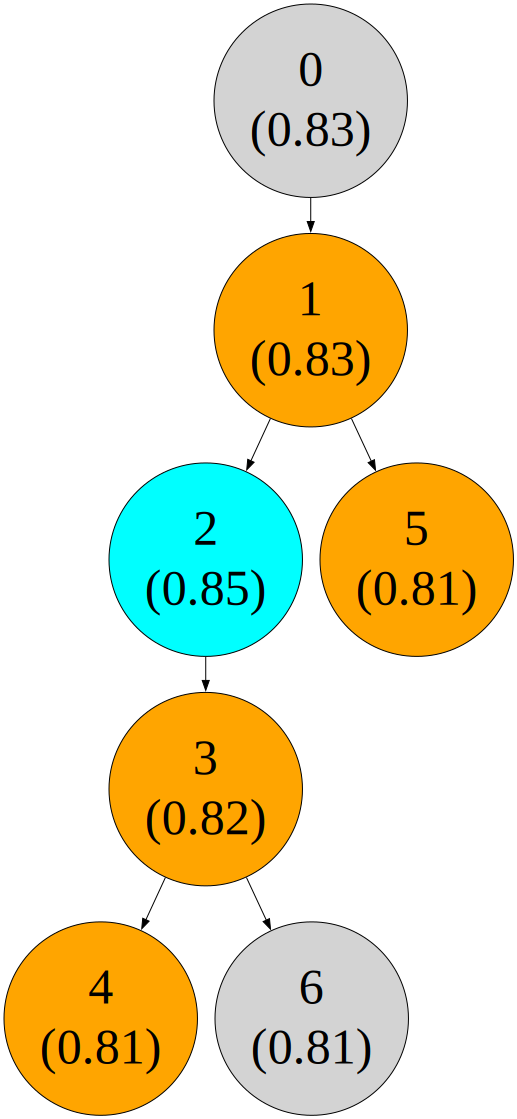

In [23]:
from IPython.display import SVG

SVG('../optimization_results/graphviz_medical_chronology.svg')

In [24]:
optimized_example = base_signature_agent.run_signature_sync(
    MedicalRecordInput(text=TEST_TEXT),
    candidate=result.best_candidate,
)

display(Markdown(str(optimized_example.output)))

2025-04-02

EMT-P Daniel Rivera, License #EMTP-21478

Patient involved in MVC at 17:20 after rear-end collision; reports neck pain (6/10) radiating to shoulders, mid-thoracic pain (5/10), mild nausea, frontal headache (4/10); denies other injuries. Physical exam: cervical tenderness at C4–C6, thoracic tenderness T6–T8, neuro intact, GCS 15. Interventions: cervical collar, long spine board, IV access, fentanyl 50 mcg IV (pain reduced from 6/10 to 4/10). Transported emergently to Starlight Regional Medical Center. Handoff at 18:09.

In [25]:
Markdown(base_output_summary)

2025-04-02

EMT-P Daniel Rivera

Emergency medical response for patient Jonathan Parker involved in rear-end motor vehicle collision. Patient displayed neck and mid-back pain, mild headache, and was transported to Starlight Regional Medical Center with cervical spine immobilization, IV access, pain medication administered, and comprehensive handoff to ED staff.